# Transfer Learning
---
## 쉽지만 중요한 코너!
## **"잘 만들어진"** 모델들을 가져다가 **"고쳐"** 사용해보자.

* [모델들은 이 링크를 참고해보자](https://www.tensorflow.org/api_docs/python/tf/keras/applications)
* [트랜스퍼 러닝?](https://miro.medium.com/max/2800/1*D5S6ylZwUZAxj0lMyipZ2g.png)

![transfer](https://raw.githubusercontent.com/DrKAI/image/main/Transfer_Learning.png)


## Library Loading

In [1]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import decode_predictions
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

from sklearn.model_selection import train_test_split

import random
import numpy as np
import matplotlib.pyplot as plt
import glob

## **Collecting Image Data**

* 최소 조건 : 클래스 3개, 한 클래스당 10장 이상. **다다익선!**
    * ImageNet data에는 확실히 없을만한 것들로. (이를테면 만화 캐릭터간 비교)
    * **좋은 결과**를 위해서라면 클래스가 확실히 차이나는 이미지로.
    * **도전(역경)**을 위해서라면 클래스가 달라도 비슷비슷해 보이는 이미지로.
---
- **순서**
    1. 구글링하여 이미지를 수집합니다.
    2. **본인의** 구글 드라이브에 my_data 폴더를 생성합니다.
    3. my_data 폴더 안에 transfer 폴더를 생성합니다.
    4. 1번 단계에서 수집한 이미지를 transfer 폴더 안에 업로드하되, **하나의 클래스당 하나의 폴더를 갖도록 정리합니다.**
    5. 30초 정도 기다립니다.
    5. 아래 코드들을 실행합니다.

## Connect Colaboratory with my Google Drive
- Colaboratory와 본인의 구글 드라이브를 연결하는 과정
- 아래 코드를 실행하여 폴더가 올바르게 생성 되었는지 확인

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cd /content/drive/MyDrive/my_data/; ls

datasets  img1	model.png	  my_mnist   MyPjt  transfer
handmade  img2	my_first_save.h5  my_mnist2  temp


In [4]:
!cd /content/drive/MyDrive/my_data/transfer; ls

armstrong  bleach  opm


In [5]:
files = glob.glob('/content/drive/MyDrive/my_data/transfer/*/*')
files

['/content/drive/MyDrive/my_data/transfer/opm/3ba41ec9dad7c14601a4bd80bbb09940.jpg',
 '/content/drive/MyDrive/my_data/transfer/opm/images.png',
 '/content/drive/MyDrive/my_data/transfer/opm/saitama-of-one-punch-man-season-2.png',
 '/content/drive/MyDrive/my_data/transfer/opm/one-punch-man-saitama-punch-canvas-art-wrap-28064182532_1024x1024.jpg',
 '/content/drive/MyDrive/my_data/transfer/opm/One-Punch-Man-trama-e-recensione-696x385.jpg',
 '/content/drive/MyDrive/my_data/transfer/opm/kisspng-one-punch-man-youtube-saitama-desktop-wallpaper-one-punch-man-5ac57d8f9cb076.9914570015228921756418.jpg',
 '/content/drive/MyDrive/my_data/transfer/opm/User_184486_Profile_Picture_20180331-093841_44ab7971-cb01-41cd-aa91-6232dceea126.jpg',
 '/content/drive/MyDrive/my_data/transfer/opm/maxresdefault.jpg',
 '/content/drive/MyDrive/my_data/transfer/opm/images.jpg',
 '/content/drive/MyDrive/my_data/transfer/opm/다운로드 (1).jpg',
 '/content/drive/MyDrive/my_data/transfer/opm/one-punch-man_1545897445533.w

In [6]:
name_cnt = {}

for x in files :
    name_cnt[x.split('/')[-2]] = name_cnt.get(x.split('/')[-2], 0) + 1

name_cnt

{'opm': 20, 'armstrong': 19, 'bleach': 19}

In [7]:
i = 0
names = {}

for key in name_cnt :
    names[key] = i     # names_cnt의 key값에 새로운 값 부여
    i += 1             # 클래스 수만큼 i값 증가

names

{'opm': 0, 'armstrong': 1, 'bleach': 2}

In [8]:
images = []
labels = []

for path in files:
    img = image.load_img(path, target_size=(299,299) )
    img = image.img_to_array(img)

    images.append(img)
    labels.append(names[path.split('/')[-2]])

    plt.imshow(image.load_img(path))
    plt.show()

images_arr = np.array(images)
labels_arr = np.array(labels)

print(images_arr.shape)
print(labels_arr.shape)

Output hidden; open in https://colab.research.google.com to view.

In [9]:
print(labels_arr)
label_v = len(np.unique(labels_arr))
label_v

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


3

In [10]:
### 라벨링
y = to_categorical(labels, label_v)

In [11]:
print(y[:3])
y.shape

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


(58, 3)

## Dataset split

- training set, validation set, test set 생성
- 각 이미지 그룹별로 균등한 분할을 위하여. 아래 코드가 조금 복잡합니다.

In [12]:
temp = []
init_v = 0

for v in name_cnt.values() :
    temp.append( (images[init_v:init_v+v], y[init_v:init_v+v]) )
    init_v += v

In [13]:
for i in range(len(temp)) :
    x_to_array = np.array(temp[i][0])
    y_to_array = np.array(temp[i][1])

    train_x, test_x, train_y, test_y =\
        train_test_split(x_to_array, y_to_array, test_size=0.2, random_state=2023)

    train_x, valid_x, train_y, valid_y =\
        train_test_split(train_x, train_y, test_size=0.2, random_state=2023)

    if i==0 :
        first_tr_x, first_va_x, first_te_x = train_x.copy(), valid_x.copy(), test_x.copy()
        first_tr_y, first_va_y, first_te_y = train_y.copy(), valid_y.copy(), test_y.copy()

    elif i==1 :
        new_tr_x, new_tr_y = np.vstack((first_tr_x, train_x)), np.vstack((first_tr_y, train_y))
        new_va_x, new_va_y = np.vstack((first_va_x, valid_x)), np.vstack((first_va_y, valid_y))
        new_te_x, new_te_y = np.vstack((first_te_x, test_x)), np.vstack((first_te_y, test_y))

    else :
        new_tr_x, new_tr_y = np.vstack((new_tr_x, train_x)), np.vstack((new_tr_y, train_y))
        new_va_x, new_va_y = np.vstack((new_va_x, valid_x)), np.vstack((new_va_y, valid_y))
        new_te_x, new_te_y = np.vstack((new_te_x, test_x)), np.vstack((new_te_y, test_y))

In [14]:
new_tr_x.shape, new_tr_y.shape, new_va_x.shape, new_va_y.shape, new_te_x.shape, new_te_y.shape

((36, 299, 299, 3),
 (36, 3),
 (10, 299, 299, 3),
 (10, 3),
 (12, 299, 299, 3),
 (12, 3))

In [15]:
# 전처리 하지 않은 파일 따로 시각화 해두기
train_xv, valid_xv, test_xv = train_x.copy(), valid_x.copy(), test_x.copy()

## Data Preprocessing
- **잘 만들어진** 모델에서 제공하는 전처리 과정을 사용합니다.

In [16]:
new_tr_x.max(), new_tr_x.min()

(255.0, 0.0)

In [17]:
new_tr_x = preprocess_input(new_tr_x)
new_va_x = preprocess_input(new_va_x)
new_te_x = preprocess_input(new_te_x)

In [18]:
new_tr_x.max(), new_tr_x.min()

(1.0, -1.0)

## Load **Pretrained** Model

In [19]:
keras.backend.clear_session()

base_model = InceptionV3(weights='imagenet',       # ImageNet 데이터를 기반으로 미리 학습된 가중치 불러오기
                         include_top=False,        # InceptionV3 모델의 아웃풋 레이어는 제외하고 불러오기
                         input_shape= (299,299,3)) # 입력 데이터의 형태

new_output = GlobalAveragePooling2D()(base_model.output)
new_output = Dense(3, # class 3개   클래스 개수만큼 진행한다.
                  activation = 'softmax')(new_output)

model = keras.models.Model(base_model.inputs, new_output)

model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

In [20]:
from tensorflow.keras.utils import plot_model

In [21]:
plot_model(model, show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

In [22]:
print(f'모델의 레이어 수 : {len(model.layers)}')

모델의 레이어 수 : 313


## **Fine-tuning**
- 모델의 가중치를 그대로 사용할 레이어와 추가 학습할 레이어를 결정합니다.

In [ ]:
model.layers

In [24]:
for idx, layer in enumerate(model.layers) :
    if idx < 213 :
        layer.trainable = False
    else :
        layer.trainable = True

In [25]:
# 처음부터 학습시키는 것도 아니고,
# 마지막 100개의 레이어만 튜닝 할 것이므로 learning rate를 조금 크게 잡아본다.

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
             optimizer=keras.optimizers.Adam(learning_rate=0.001) )

## Image Data Augmentation & Callbacks

In [26]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=4,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=0.000001)

es = EarlyStopping(monitor='val_loss',
                   min_delta=0, # 개선되고 있다고 판단하기 위한 최소 변화량
                   patience=8,  # 개선 없는 epoch 얼마나 기달려 줄거야
                   verbose=1,
                   restore_best_weights=True)

In [27]:
trainIDG = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=180, # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.3, # Randomly zoom image
    width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.3,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True)  # randomly flip images

validIDG = ImageDataGenerator()

In [28]:
trainIDG.fit(train_x)
validIDG.fit(valid_x)

In [29]:
flow_trainIDG = trainIDG.flow(train_x, train_y)
flow_validIDG = validIDG.flow(valid_x, valid_y)

## .fit( )

In [30]:
# 데이터를 넣어서 학습시키자!
hist = model.fit(flow_trainIDG, validation_data=flow_validIDG,
                 epochs=1000, verbose=1,
                 callbacks=[es, lr_reduction]
                 )

Epoch 1/1000
1/1 [==============================] - 31s 31s/step - loss: 0.9249 - accuracy: 0.7500 - val_loss: 14.0317 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/1000
1/1 [==============================] - 1s 602ms/step - loss: 0.5820 - accuracy: 0.7500 - val_loss: 0.0033 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/1000
1/1 [==============================] - 1s 523ms/step - loss: 0.1278 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/1000
1/1 [==============================] - 0s 422ms/step - loss: 0.0316 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/1000
1/1 [==============================] - 1s 517ms/step - loss: 0.0355 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/1000
1/1 [==============================] - 0s 371ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/1000
1/1 [==============================] - 0s 353

## Result

In [31]:
model.evaluate(test_x, test_y) ## [loss, accuracy]

1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

In [32]:
y_pred = model.predict(test_x)
y_pred

1/1 [==============================] - 1s 1s/step


array([[2.1487143e-30, 4.1730422e-24, 1.0000000e+00],
       [5.7259425e-10, 8.6654088e-09, 1.0000000e+00],
       [8.9091756e-35, 1.0757881e-26, 1.0000000e+00],
       [4.2603377e-15, 1.1493484e-10, 1.0000000e+00]], dtype=float32)

In [33]:
to_names = { v:k for k,v in names.items() }

------------------------------------------------------
실제 정답 : bleach vs 모델의 예측 : bleach 
opm : 0.00%  armstrong : 0.00%  bleach : 100.00%  


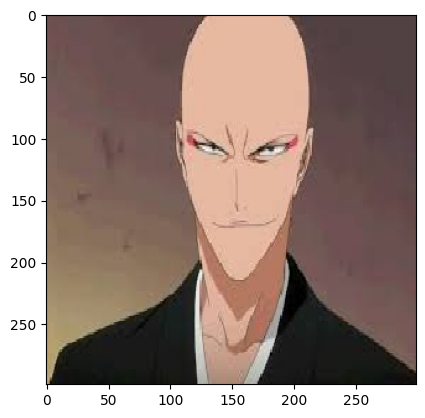

------------------------------------------------------
실제 정답 : bleach vs 모델의 예측 : bleach 
opm : 0.00%  armstrong : 0.00%  bleach : 100.00%  


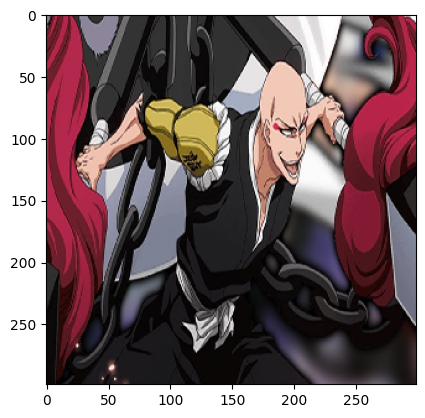

------------------------------------------------------
실제 정답 : bleach vs 모델의 예측 : bleach 
opm : 0.00%  armstrong : 0.00%  bleach : 100.00%  


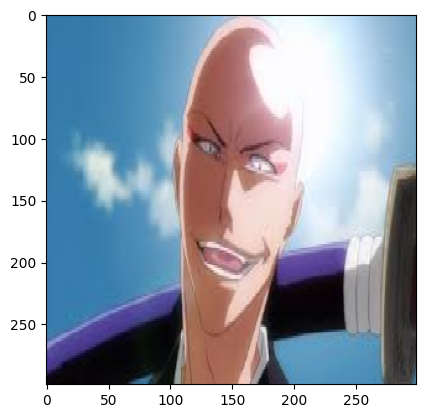

------------------------------------------------------
실제 정답 : bleach vs 모델의 예측 : bleach 
opm : 0.00%  armstrong : 0.00%  bleach : 100.00%  


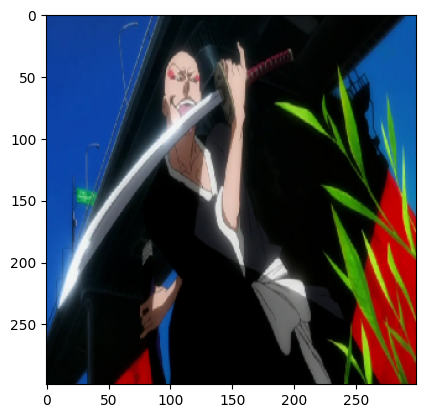

In [34]:
for i in range(len(test_x)) :
    print('------------------------------------------------------')
    print(f'실제 정답 : {to_names[test_y[i].argmax()]} vs 모델의 예측 : {to_names[y_pred[i].argmax()]} ')
    prob = ''

    for j in to_names :
        string = f'{to_names[j]} : {y_pred[i][j]*100:.2f}%  '
        prob = prob + string
    print(prob)
    plt.imshow(test_xv[i].reshape([299,299,3])/255)
    plt.show()